In [9]:
import os
import glob
#import librosa 
import numpy as np
import soundfile as sf
from essentia.standard import *
import matplotlib.pyplot as plt

from tqdm import tqdm
from essentia.standard import *
from scipy.signal import butter, lfilter

eps = np.finfo(np.float64).eps

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
%config InlineBackend.figure_format = 'retina'

In [10]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [11]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [12]:
def normalized_mean_spectrum(audio_file, win_length=1024, pad_factor=1, ratio_density=256, fs=22050):
    
    # load audio
    #data, fs = sf.read(audio_file)
    
    # we start by instantiating the audio loader
    loader = essentia.standard.MonoLoader(filename=audio_file, sampleRate=fs)

    # and then we actually perform the loading
    audio = loader()
    
    # apply a bandpass filter to focus on speech
    #audio = butter_bandpass_filter(audio, 50, 7500, fs, order=5)
    
    w = Windowing(type='hamming')
    spectrum = Spectrum()
    spectralPeaks = SpectralPeaks(magnitudeThreshold=0,
                                  maxFrequency=5000,
                                  maxPeaks=ratio_density,
                                  minFrequency=50,
                                  sampleRate=fs) 
    
    pool = essentia.Pool()

    for frame in FrameGenerator(audio, frameSize=1024, hopSize=512, startFromZero=True):
        frequencies, magnitudes = spectralPeaks(spectrum(w(frame)))
        pool.add('lowlevel.frequencies', frequencies)
        pool.add('lowlevel.magnitudes', magnitudes)
                  
    ratio_idxs = np.linspace(0.0, 2.5, ratio_density)       
    freq_data_mean_ln = np.zeros(shape=(ratio_density,))
    
    for freqs, mags in zip(pool['lowlevel.frequencies'], pool['lowlevel.magnitudes']):
        
        if len(freqs) < 1 or len(mags) < 1:
            continue
        
        f0_freq = freqs[np.argmax(mags)]
        f0_mag = np.max(mags)
        
        for peak_freq, peak_mag in zip(freqs, mags):
            current_ratio = peak_freq / f0_freq
            
            if current_ratio > 2.5:
                break
            
            ratio_idx = np.squeeze(np.argwhere(ratio_idxs == find_nearest(ratio_idxs, current_ratio)))
            freq_data_mean_ln[ratio_idx] += peak_mag
        
    #data = audio    
    # peform STFT
    #freq_data_ln = np.abs(librosa.core.stft(data, 
    #                                        win_length=win_length,
    #                                        window='hamming', 
    #                                        n_fft=win_length*pad_factor))
    
    # conver to dB
    #freq_data_db = librosa.amplitude_to_db(freq_data_ln, ref=np.max)
    
    #print(freq_data_db.shape)
    
    # throw away silent frames
    #freq_data_ln = freq_data_ln[:,np.where(np.max(freq_data_db, axis=1) > -80)[0]]
    #freq_data_db = freq_data_db[:,np.where(np.max(freq_data_db, axis=1) > -80)[0]]
    
    # find the frequency peak in the sprectrum
    #f0_idx = np.argmax(freq_data_db, axis=0)
    #f0_hz  = f0_idx * ((fs/2)/((win_length*pad_factor)/2))
    #f0_a   = np.max(freq_data_db, axis=0)

    #freq_data_mean_ln = np.zeros(shape=(ratio_density,))
    #ratio_idx = np.linspace(0.0, 2.5, ratio_density)
    
    #for frame_idx in np.arange(0, freq_data_ln.shape[1]):
    #    for bin_idx in np.arange(1, freq_data_ln.shape[0]):
            
            #current_idx = f0_idx[frame_idx] + bin_idx
            #current_ratio = (current_idx + 1) / (f0_idx[frame_idx] + 1)
            
            # skip frame if f0 is DC
     #       if f0_idx[frame_idx] == 0 or f0_a[frame_idx] < -40:
     #           break
            
      #      current_ratio = (bin_idx) / (f0_idx[frame_idx])
      #      r_idx = np.squeeze(np.argwhere(ratio_idx == find_nearest(ratio_idx, current_ratio)))
      #      
      #      #print(bin_idx, current_ratio, r_idx)
      #      
      #      # skip frame if harmonic is beyond octave
      #      if current_ratio > 2.5: 
       #         break
    
       #     freq_data_mean_ln[r_idx] += freq_data_ln[bin_idx, frame_idx]
    
    # normalize
    freq_data_mean_ln /= freq_data_mean_ln.shape[0]
        
    # convert to db
    #freq_data_mean_db = 20 * np.log10(freq_data_mean_ln + np.finfo(np.float32).eps)
    #freq_data_mean_db = librosa.amplitude_to_db(freq_data_mean_ln, ref=np.max)
    
    return freq_data_mean_ln


In [13]:
def plot_mean_spectrum(ratio_idx, freq_data_mean_db):
    
    common = [1/1, 6/5, 5/4, 4/3, 7/5, 3/2, 8/5, 5/3, 9/5, 2/1]
    
    plt.plot(ratio_idx, freq_data_mean_db, c='r', zorder=2)
    #for ratio in common:
    #    plt.axvline(ratio_idx[np.argwhere(ratio_idx == find_nearest(ratio_idx, ratio))],
    #                c='k', zorder=1, linewidth=0.5)
    plt.xticks(common, rotation=70)
    plt.xlim([0.95, 2.1])
    plt.ylim([-60,3])
    plt.ylabel('Mean amplitude (dB)')
    plt.xlabel('f0 ratio')
    plt.grid()
    plt.show()
    #plot_path = os.path.join('plots', os.path.basename(audio_file).replace('flac', 'png'))
    #plt.savefig(plot_path, dpi=300, bbox_inches='tight')

In [14]:
def analyze_dataset(audio_files):
    
    if len(audio_files) < 1:
        print("No audio files...")
        return
    
    freq_data_mean_ln = np.zeros(256)
    
    for audio_file in tqdm(audio_files):
        freq_data_mean_ln += normalized_mean_spectrum(audio_file)
        
    freq_data_mean_ln /= len(audio_files)
    #freq_data_mean_db = librosa.amplitude_to_db(freq_data_mean_ln, ref=np.max)
    freq_data_mean_db = 20 * np.log10((freq_data_mean_ln + eps)/np.max(freq_data_mean_ln + eps))
    
    ratio_idx = np.linspace(0.0, 2.5, 256)
    plot_mean_spectrum(ratio_idx, freq_data_mean_db)
    
    

100%|██████████| 1/1 [00:01<00:00,  1.50s/it]


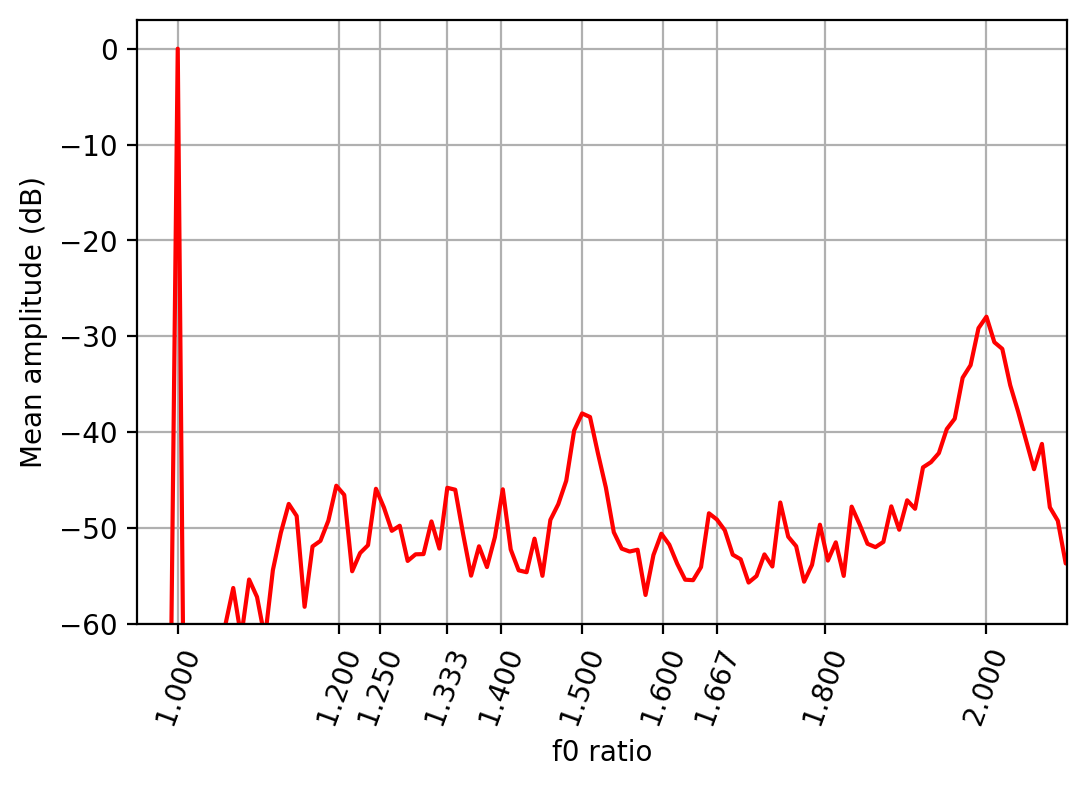

In [15]:
javanese1 = 'audio/nila_speaking_javanese.wav'
analyze_dataset([javanese1])

100%|██████████| 1/1 [00:04<00:00,  4.63s/it]


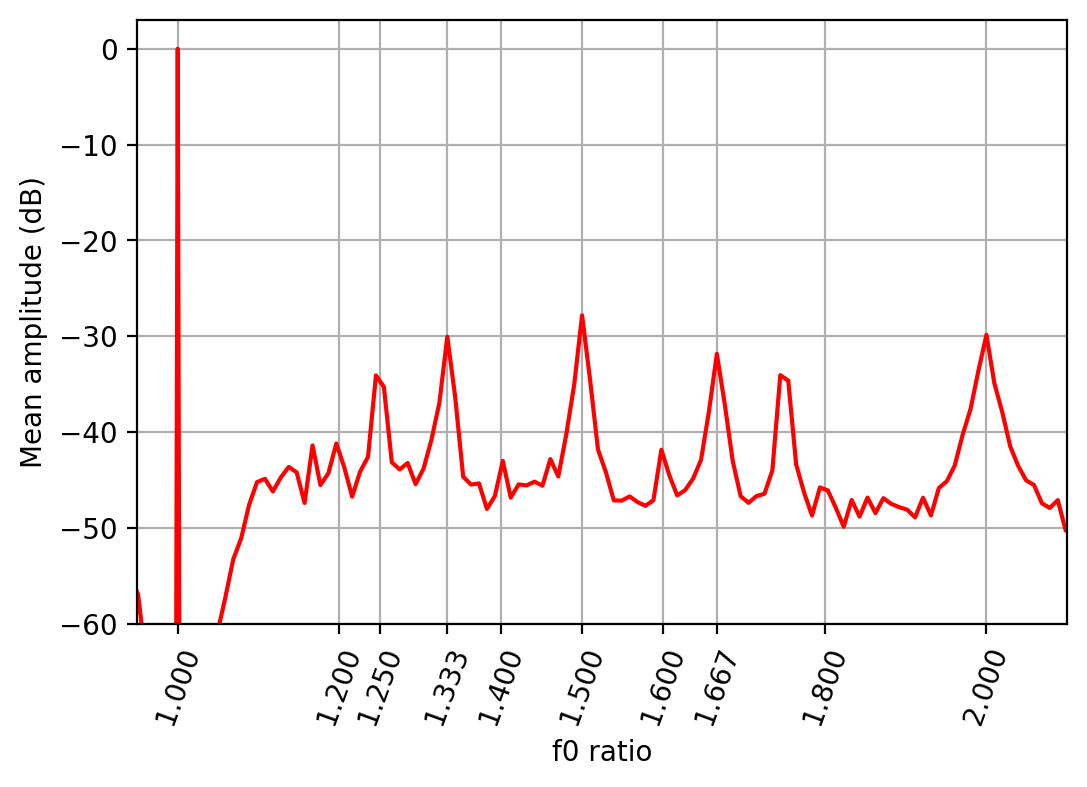

In [16]:
javanese2 = 'audio/rama_speaking_javanese.wav'
analyze_dataset([javanese2])

100%|██████████| 1/1 [00:03<00:00,  3.37s/it]


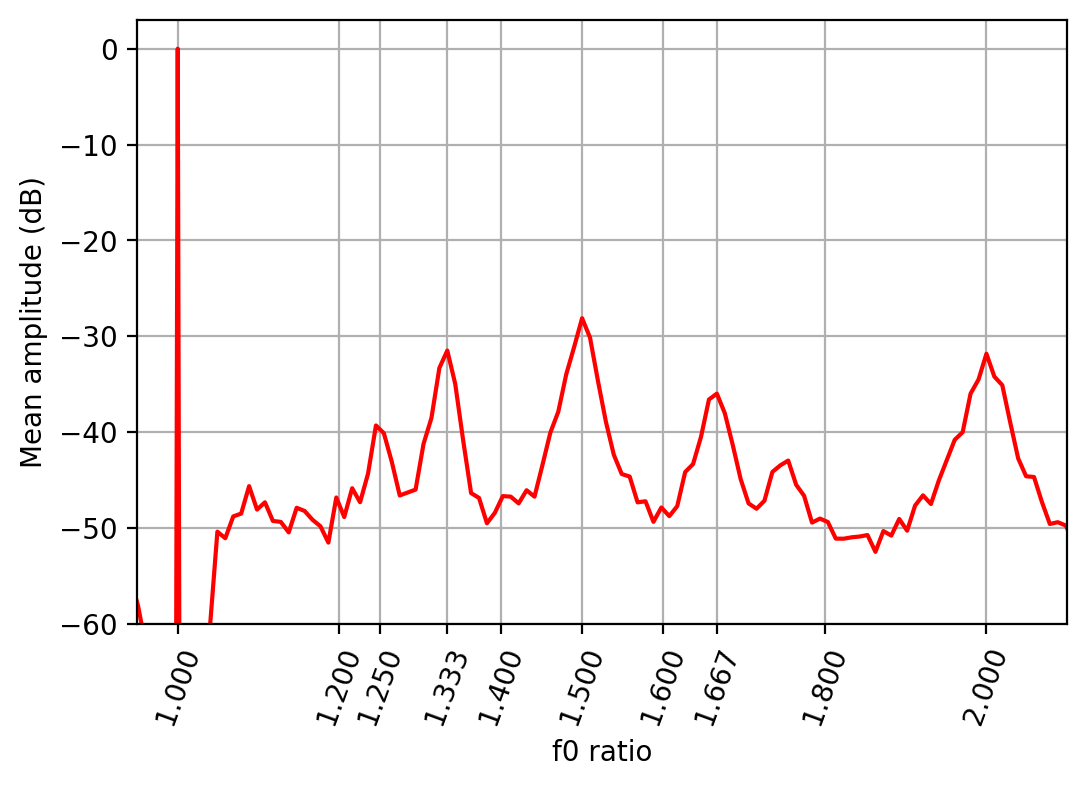

In [17]:
catalan = 'audio/ona_speaking_catalan.wav'
analyze_dataset([catalan])

100%|██████████| 1/1 [00:03<00:00,  3.48s/it]


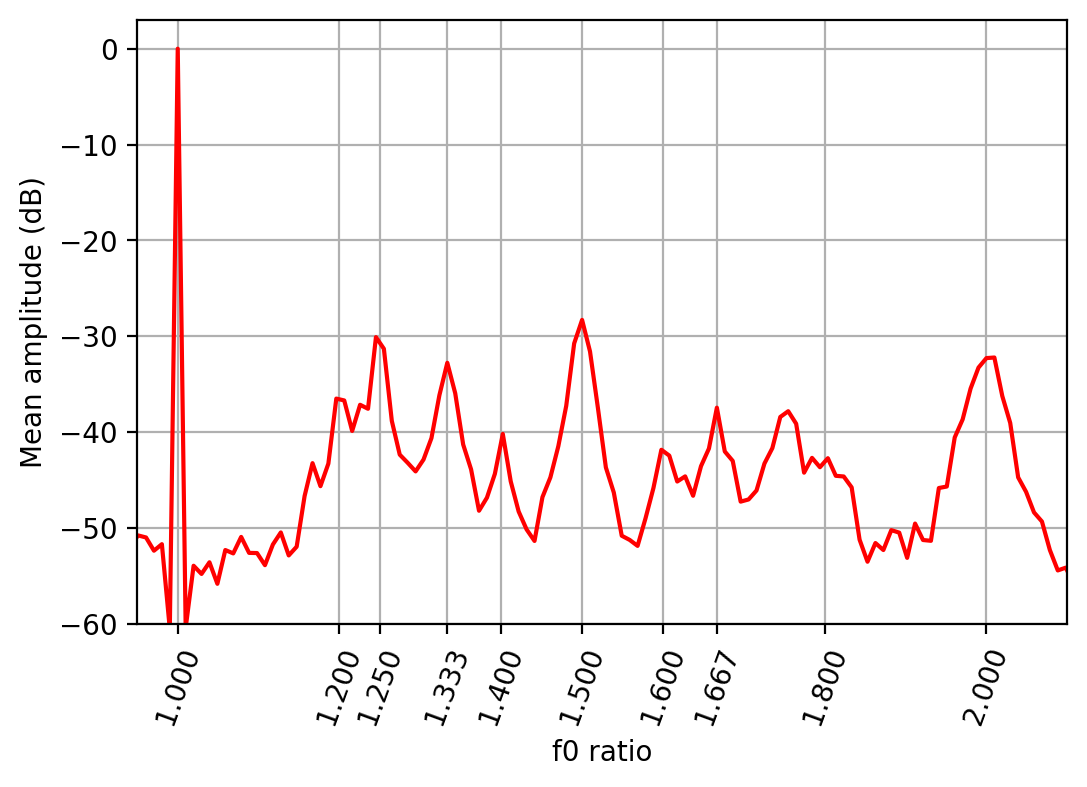

In [18]:
english = 'audio/liam_speaking_english.wav'
analyze_dataset([english])

100%|██████████| 4/4 [00:13<00:00,  3.30s/it]


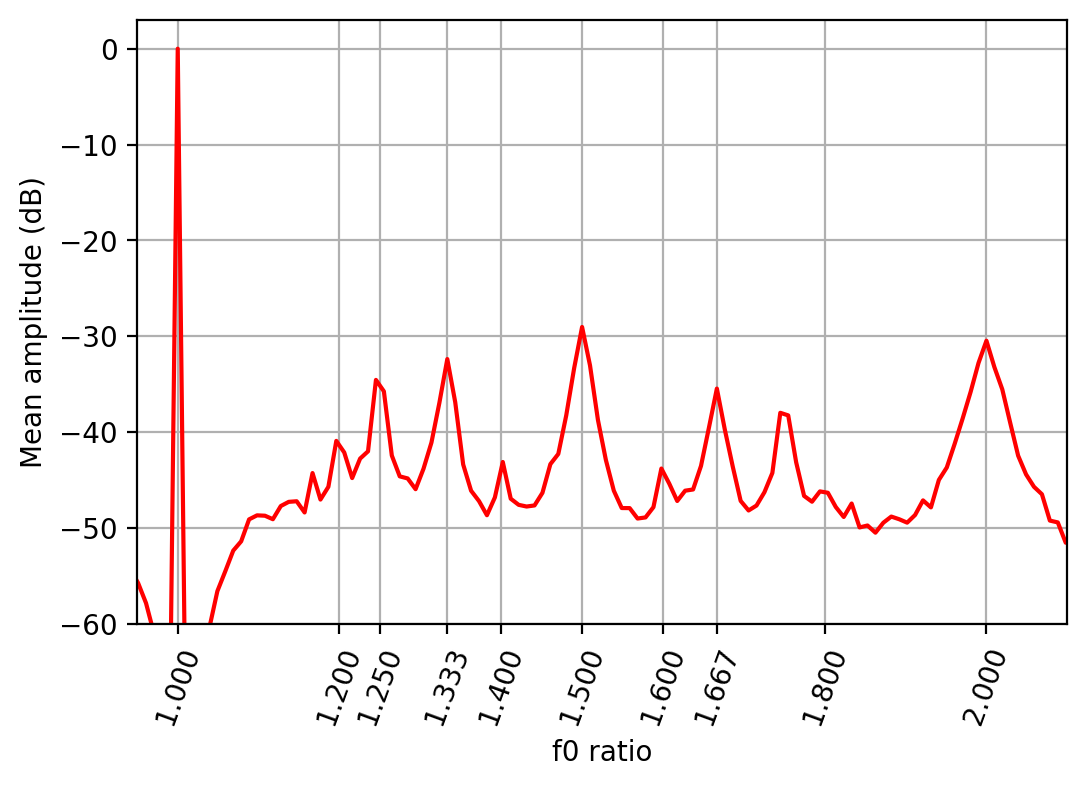

In [19]:
analyze_dataset([javanese1, javanese2, catalan, english])

In [26]:
chinese = glob.glob('/Volumes/SteinmetzAlpha/Datasets/chinese-single-speaker-speech-dataset/**/*.wav')[:10000]

100%|██████████| 2971/2971 [08:32<00:00,  5.80it/s]


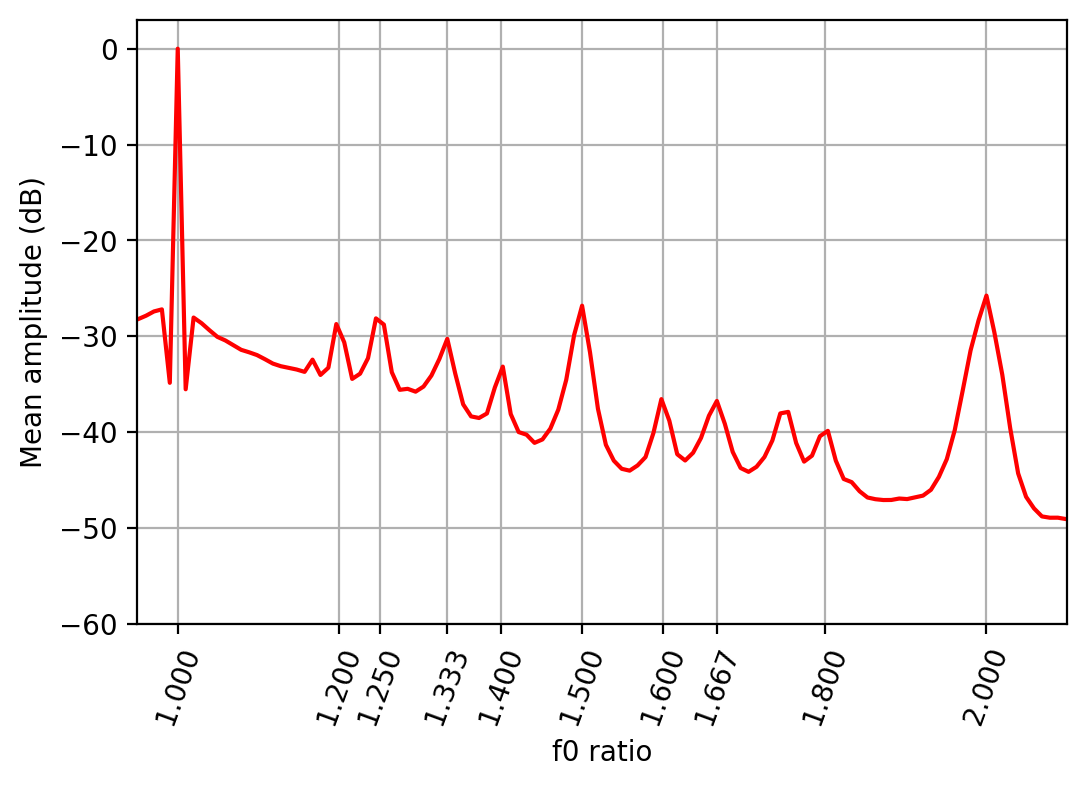

In [27]:
analyze_dataset(chinese)

In [ ]:
libri = glob.glob('/Volumes/SteinmetzAlpha/Datasets/LibriSpeech/dev-clean/**/**/*.flac')[:10000]
analyze_dataset(libri)